# Optical flow experiments

## Horizontal pixel displacement


How much does a 3D point move horizontally relative to the concentric mosaic camera?

![Overview](jupyter_files/overview.png)

 $p(\alpha)=(d+r) \begin{bmatrix}\cos(\alpha)\\\sin(\alpha)\\h\end{bmatrix}$: 3D point
 
 $d$: distance of point to capture circle
 
 $r$: capture circle radius
 
 $h$: height of 3D point (perpendicular to drawing plane)
 
 $\alpha$: point's global azimuth angle relative to camera's principal axis
 
 $\beta$: point's azimuth in camera coordinate frame
 
 $c = (d+r) \sin(\alpha)$
 
 $e = (d+r) \cos(\alpha)$
 
 $\tan(\beta) = \frac{c}{e-r} = \frac{(d+r)\sin(\alpha)}{(d+r)\cos(\alpha)-r}$
 
 

### In equirectangular projection

$$\beta = \arctan\left(\frac{(d+r)\sin(\alpha)}{(d+r)\cos(\alpha)-r}\right)$$

In [29]:
# Vary r and d(>r)
d = 3.0
r = 0.5

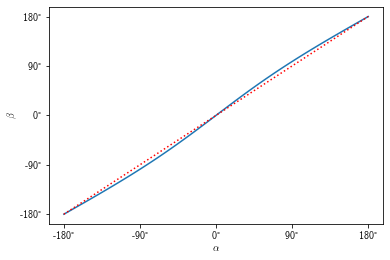

In [30]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)

𝛼 = np.linspace(-np.pi, np.pi, 100)

𝛽 = np.arctan2((d+r)*np.sin(𝛼), (d+r)*np.cos(𝛼)-r)

plt.plot(𝛼, 𝛽)
ticks = np.r_[-180:181:90]
plt.xticks(ticks*np.pi/180, [str(t)+'°' for t in ticks])
plt.yticks(ticks*np.pi/180, [str(t)+'°' for t in ticks])
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.plot(𝛼, 𝛼, 'r:')
plt.show()

### In pinhole projection

$$x = f \frac{c}{e-r} = f \tan(\beta) = f \frac{(d+r)\sin(\alpha)}{(d+r)\cos(\alpha)-r}, \quad \text{$f$: focal length}$$


In [31]:
# Vary FOV between, for example, 20° and 180°
horizontal_fov = 60 /180*np.pi

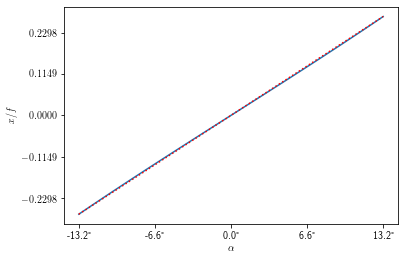

In [32]:
max_𝛼 = np.arctan2( d * np.tan(horizontal_fov/2), d + r)
𝛼 = np.linspace(-max_𝛼/2, max_𝛼/2, 100)
x = (d+r)*np.sin(𝛼)/((d+r)*np.cos(𝛼)-r)
plt.plot(𝛼, x)
ticks = np.linspace(-max_α/2, max_α/2, 5)
plt.xticks(ticks, [f'{t*180/np.pi:.1f}°' for t in ticks])
plt.yticks(ticks)
plt.xlabel('$\\alpha$')
plt.ylabel('$x/f$')
plt.plot([-max_α/2, max_α/2], x[[0,-1]], 'r:')
plt.show()

### Summary

In both cases, pinhole and equirecatangular, the horizontal pixel displacement of a uniformly moving 3D point is *not* perfectly linear. Especially for points close to the camera and for wide fields of view, the mapping between relative angular point-camera position and horizontal displacement in the image has a slight S-shape.

For small changes in 𝛼, however, the local behaviour can be approximated with a linear function.

## Optical flow as measure for relative angular position

Using any dense optical flow method from OpenCV, test if occlusions and other inconsistencies can be detected by chaining the optical flows $\texttt{frame}_A \rightarrow \texttt{frame}_B$ and $\texttt{frame}_B\rightarrow \texttt{frame}_A$ and testing for small deviations.

Also check if the ratio of horizontal optical flow magnitudes reliably represents the angular position of $\texttt{frame}_0$ halfway between $\texttt{frame}_{N-1}$ and $\texttt{frame}_{N}$, i.e. if

$$
 \frac{\left|f^x_{0,N-1}(x,y)\right|}{\left|f^x_{0,N}(x,y)\right|} =  \frac{\delta}{\Delta\alpha-\delta}
$$
or
$$
 \frac{\left|f^x_{0,N-1}(x,y)\right|}{\left|f^x_{0,N}(x,y)\right|+\left|f^x_{0,N-1}(x,y)\right|} =  \frac{\delta}{\Delta\alpha}
$$

![Loop closure](jupyter_files/loop_closure.png)

For reference, in Numpy notation, OpenCV defines the flow $f_{A,B}$ between $\texttt{frame}_A$ and $\texttt{frame}_B$ by
$$\texttt{frame}_A [y,x,:]  \sim \texttt{frame}_B \left[ y + f_{A,B}[y,x,1],  x + f_{A,B}[y,x,0], :\right]$$

In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload 1
%aimport video_loop_finder

import cv2
import numpy as np
from matplotlib import pyplot as plt
from video_loop_finder import VideoLoopFinder


flow_algo = cv2.optflow.createOptFlow_Farneback()

start_frame_idx = 990
closest_end_frame_idx = 2790
video_loop_finder = VideoLoopFinder('/home/florians/Videos/VID_2019_09_26_14_02_58_20191015155545.mp4',
                                    start_frame_idx=start_frame_idx,
                                    resolution=256)

# For testing, use frames 999(≙N-1), 1000(≙0), 1000+x(≙N) => expected outcome: Δ𝛼=(1+x)𝛿
x = 1
frame_0 = video_loop_finder._seek(1000)
frame_N = [video_loop_finder._seek(1000 + x), 
           video_loop_finder._seek(999)]

# Opt. flow from frame N to 0 and its reverse
flow_N = (flow_algo.calc(frame_N[0], frame_0, None), 
           flow_algo.calc(frame_0, frame_N[0], None))
# Opt. flow from 0 to N-1 and its reverse
flow_0 = (flow_algo.calc(frame_0, frame_N[1], None),
          flow_algo.calc(frame_N[1], frame_0, None))

INFO	Input loaded: video_duration=4511
INFO	Looping direction appears to be CW


In [35]:
def directional_colorbar(axes):
    for angle in np.linspace(-np.pi,np.pi):
        axes.bar(angle, 1, color=colors.hsv_to_rgb((angle/2/np.pi+0.5,1.0,1.0)))
    axes.set_yticks([])
    axes.set_xticklabels([f'{h}°' for h in [*range(0,181, 45), *range(-135,0,45)]])
    axes.set_position([0.55,0.4, 0.2,0.2])

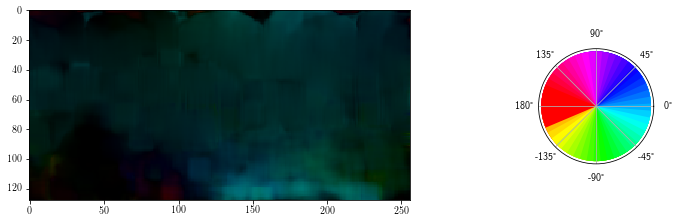

In [36]:
# Sanity check: visualize flow

from matplotlib import colors

flow_to_plot = flow_0

plt.set_cmap(plt.cm.jet)
hue = np.arctan2(flow_to_plot[0][...,1], flow_to_plot[0][...,0]) / 2/np.pi + 0.5
value = np.linalg.norm(flow_to_plot[0], axis=-1)
rgb = colors.hsv_to_rgb(np.dstack((hue, np.ones_like(hue), 1-np.exp(-value))))

fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(8)
ax = fig.add_subplot(121), fig.add_subplot(122, polar=True)
im = ax[0].imshow(rgb)
im.format_cursor_data = lambda d: (f'dir: {(colors.rgb_to_hsv(d)[0]-0.5)*360:.0f}°, '
                                   f'mag: {colors.rgb_to_hsv(d)[2]:.3f}')
directional_colorbar(ax[1])


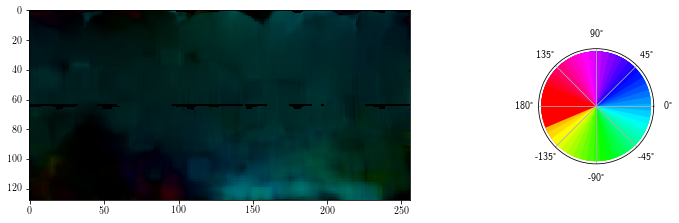

In [37]:
# Visualise filtering result

# Vary threshold
filter_threshold = 0.2

from video_loop_finder import VideoLoopFinder

filter_optical_flow = VideoLoopFinder.filter_optical_flow

filtered_flow = filter_optical_flow(flow_to_plot[0], flow_to_plot[1], filter_threshold)

hue = np.arctan2(filtered_flow[...,1], filtered_flow[...,0]) / 2/np.pi + 0.5
value = np.linalg.norm(filtered_flow, axis=-1)
rgb = colors.hsv_to_rgb(np.dstack((hue, np.ones_like(hue), 1-np.exp(-value))))
rgb[np.any(filtered_flow.mask, -1),:] = np.nan

fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(8)
ax = fig.add_subplot(121), fig.add_subplot(122, polar=True)
im = ax[0].imshow(rgb)
im.format_cursor_data = lambda d: (f'dir: {(colors.rgb_to_hsv(d)[0]-0.5)*360:.0f}°, '
                                   f'mag: {colors.rgb_to_hsv(d)[2]:.3f}')
directional_colorbar(ax[1])
plt.show()

In [38]:
import pixiedust

WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasing --flow-filter threshold
WARNING	More than 50% of optical flow vectors have been filtered out. Consider increasin

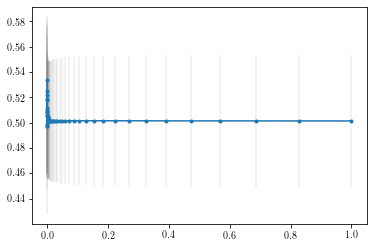

In [39]:
# %%pixie_debugger -b24

filter_thresholds = np.logspace(-4,0)
filter_optical_flow = VideoLoopFinder.filter_optical_flow

output_ratios = []
output_std = []
for filter_threshold in filter_thresholds:
    # Horizontal component of flow from 0 to N-1
    xflow_0_to_end = np.abs(filter_optical_flow(flow_0[0], flow_0[1], filter_threshold)[...,0]).filled()
    
    # Horizontal component of flow from 0 to N
    xflow_0_to_N = np.abs(filter_optical_flow(flow_N[1], flow_N[0], filter_threshold)[...,0]).filled()

    xflow_sum = xflow_0_to_N + xflow_0_to_end
    δ_over_Δ𝛼 = np.nanmedian(xflow_0_to_end[xflow_sum != 0] / xflow_sum[xflow_sum != 0])
    
#     print(f'{filter_threshold:0.4f}', δ_over_Δ𝛼)
    output_ratios.append(δ_over_Δ𝛼)
    output_std.append(np.nanstd(xflow_0_to_end[xflow_sum != 0] / xflow_sum[xflow_sum != 0]) / 2)
plt.errorbar(filter_thresholds, output_ratios, output_std, fmt='.-', ecolor='gray', elinewidth=.2)
plt.show()


### Summary

The outlier detection based on chaining optical flows in forward and backward direction appears to work.

Determining the ratio of $\delta$ to $\Delta\alpha$ from optical flow ratios works reliably, and appears to give stable results for outlier thresholds above 0.1 pixels.